# Doc 6.1 - CNNs com data augmentation e transfer learning

A partir da documentação 6, percebeu-se que o número de imagens não foi suficiente para as redes aprenderem a separar e classificar as classes de imagens apropriadamente. 

Com isso, nessa documentação, usou-se data augmentation para aumentar o número de imagens de classe "benign" e "cancer" a fim de analisar se isso poderia ajudar a rede a aprender.

## 1 - Análise inicial de dados

In [1]:
#Imports padrão para o desenvolvimento da rede e visualização do dataset
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau #Interessante esse aqui - redução do LR se a validation n melhorar
from tensorflow.keras.applications import DenseNet121
from keras.applications import VGG16
from keras.models import Model

#Imports 
import pydicom as dicom
import matplotlib.pylab as plt
import pandas as pd
import os
import numpy as np
from tabulate import tabulate
import tensorflow_io as tfio
import tensorflow as tf
import cv2
from collections import Counter
from PIL import Image
from pydicom.pixel_data_handlers.util import apply_voi_lut
import shutil
from pathlib import Path
import imagesize
import splitfolders
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

C:\Users\breno\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Text(0.5, 1.0, 'Frequencia de categoria one hot no dataset de teste')

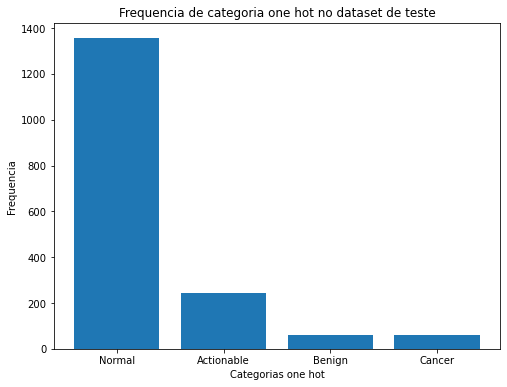

In [2]:
labels = pd.read_csv(r"D:\Coisinhas\Coisas_UNB\TCC\dataset_dcm\test\manifest-1617905855234\BCS-DBT-labels-test-PHASE-2.csv") #Arquivo dos diagnosticos

one_hot_sum = labels[['Normal', 'Actionable', 'Benign', 'Cancer']].sum()

plt.figure(figsize=(8, 6))

plt.bar(['Normal', 'Actionable', 'Benign', 'Cancer'], one_hot_sum)

plt.xlabel('Categorias one hot')
plt.ylabel('Frequencia')
plt.title('Frequencia de categoria one hot no dataset de teste')

In [3]:
one_hot_sum

Normal        1356
Actionable     244
Benign          61
Cancer          60
dtype: int64

Como tem-se uma quantidade muito maior de imagens de label "Normal", vou pegar 300 delas para deixar o dataset um pouco mais balanceado e depois fazer data augmentation para aumentar o número de "Benign" e "Cancer".

### 1.1 - Criação do novo folder

In [4]:
original_folder = r"D:\Coisinhas\Coisas_UNB\TCC\dataset_png\test"
balanced_folder = r"data"

counts = {
    "normal": 300,
    "actionable": 240,
    "benign": 61,  
    "cancer": 60   
}

for category, count in counts.items():
    #Pega as classes
    category_images = os.listdir(os.path.join(original_folder, category))
    #Pega imagens aleatórias de cada classe
    random_images = random.sample(category_images, count)
    #Cria o folder da classe
    os.makedirs(os.path.join(balanced_folder, category), exist_ok=True)
    #Joga as imagens da classe no seu respectivo folder
    for image in random_images:
        shutil.copy(os.path.join(original_folder, category, image), os.path.join(balanced_folder, category))

### 1.2 - Resize das imagens

In [5]:
def resize_images(folder_path, target_size):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".png"): 
                file_path = os.path.join(root, file)
                image = Image.open(file_path)
                if image.size != target_size:
                    resized_image = image.resize(target_size, Image.ANTIALIAS)
                    resized_image.save(file_path)
                    

folder_path = r"D:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 6.1 - CNNs com data augmentation e transfer learning\data"
target_size = (1890, 2457) #Vamos primeiro dar o resize nas imagens que não têm essas dimensões.
resize_images(folder_path, target_size)

C:\Users\breno\AppData\Local\Temp\ipykernel_13688\684464633.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(target_size, Image.ANTIALIAS)


In [6]:
#Agora damos um resize de 4 vezes menor.
target_size = (1890//4, 2457//4)
resize_images(folder_path, target_size)

C:\Users\breno\AppData\Local\Temp\ipykernel_13688\684464633.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(target_size, Image.ANTIALIAS)


In [7]:
input_folder = 'data' 
output_folder = 'split_data' 

splitfolders.ratio(input_folder, output_folder, seed=42, ratio=(.7, .15, .15), group_prefix=None) #Train/val/test

Copying files: 661 files [00:02, 225.32 files/s]


In [8]:
train_dir = 'split_data/train' 
val_dir = 'split_data/val' 
test_dir = 'split_data/test' 

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    vertical_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(1890//4, 2457//4),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(1890//4, 2457//4),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(1890//4, 2457//4),
    batch_size=16,
    class_mode='categorical'
)

Found 462 images belonging to 4 classes.
Found 99 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [11]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

for layer in base_model.layers:
    layer.trainable = False
    
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)


model_densenet = Model(inputs=base_model.input, outputs=predictions)

model_densenet.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_densenet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 472, 614, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_2              │ (None, 478, 620, 3)       │               0 │ input_layer_1[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 236, 307, 64)      │           9,408 │ zero_padding2d_2[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 236, 307, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 236, 307, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_3              │ (None, 238, 309, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 118, 154, 64)      │               0 │ zero_padding2d_3[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 118, 154, 64)      │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 118, 154, 64)      │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 118, 154, 128)     │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 118, 154, 128)     │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 118, 154, 128)     │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 118, 154, 32)      │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 118, 154, 96)      │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 41,903,300 (159.85 MB)

 Trainable params: 34,865,796 (133.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [12]:
history_densenet = model_densenet.fit(train_generator, epochs=50, validation_data=val_generator)

Epoch 1/50


C:\Users\breno\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 254s 8s/step - accuracy: 0.3337 - loss: 5.6871 - val_accuracy: 0.4747 - val_loss: 1.2780
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 228s 8s/step - accuracy: 0.4581 - loss: 1.3323 - val_accuracy: 0.4848 - val_loss: 1.3065
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 221s 8s/step - accuracy: 0.4969 - loss: 1.1762 - val_accuracy: 0.5051 - val_loss: 1.3440
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 228s 8s/step - accuracy: 0.5482 - loss: 1.0557 - val_accuracy: 0.5758 - val_loss: 1.1632
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 227s 8s/step - accuracy: 0.5888 - loss: 0.9783 - val_accuracy: 0.4949 - val_loss: 1.2617
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 220s 8s/step - accuracy: 0.5835 - loss: 0.9969 - val_accuracy: 0.4646 - val_loss: 1.1266
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 224s 8s/step - accuracy: 0.6367 - loss: 0.8990 - val_accuracy: 0.3737 - val_loss: 1.3231
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 226s 8s/step - accuracy: 0.6030 - loss: 0.9168 - val_accuracy: 0.4646 - val_loss: 1.

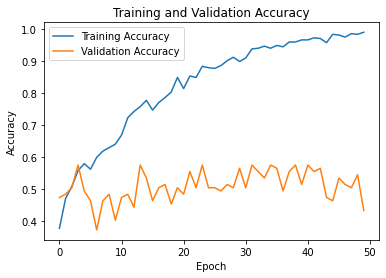

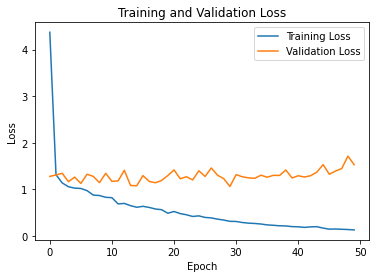

In [13]:
#Analise da precisao do treinamento e validacao
plt.plot(history_densenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history_densenet.history['loss'], label='Training Loss')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
test_loss, test_accuracy = model_densenet.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.4810 - loss: 1.5691
Test Accuracy: 42.00%
Test Loss: 1.7030


In [15]:
predictions = model_densenet.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step


array([3, 3, 0, 3, 3, 0, 0, 3, 0, 1, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 0, 3,
       3, 3, 0, 3, 3, 3, 0, 0, 3, 3, 0, 0, 2, 0, 0, 3, 0, 3, 3, 3, 0, 3,
       0, 3, 3, 3, 3, 3, 0, 3, 0, 3, 0, 0, 3, 3, 3, 3, 2, 0, 0, 3, 0, 0,
       0, 3, 0, 0, 3, 0, 3, 3, 0, 0, 0, 3, 3, 2, 0, 3, 0, 3, 0, 0, 3, 3,
       1, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 0], dtype=int64)

In [16]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [17]:
#Pega os indices que foram classificados errados (i.e. vai pegar o indice dos dois arrays que estao diferentes EM VALOR)
misclassified_indices = np.where(predicted_labels != true_labels)[0]
misclassified_indices

array([ 0,  1,  3,  4,  7,  9, 10, 11, 12, 13, 16, 17, 18, 21, 22, 23, 25,
       26, 27, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 60, 61, 62, 64, 65, 66, 68, 69, 71,
       74, 75, 76, 79, 80, 82, 84, 85, 88, 92, 93, 99], dtype=int64)

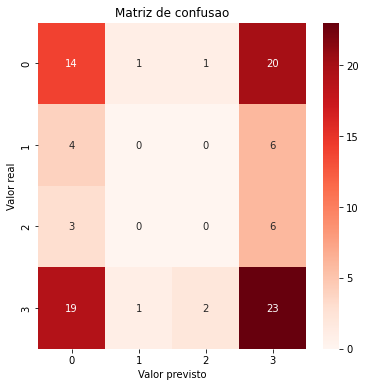

In [18]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [22]:
model_densenet.save("model_densenet1.keras")